## Importing Libraries

In [1]:
# This is used to autoreload updates made in co_mof.py
%load_ext autoreload
%autoreload 2

## Image Processing with RC Thresholding

This script processes an image by converting it to grayscale and applying **Ridler-Calvard (RC) thresholding** for segmentation.

### Steps:
1. **Load Image**: Reads an image from the specified path.
2. **Convert to Grayscale**: Prepares the image for thresholding.
3. **Apply RC Thresholding**: Segments the image using the Ridler-Calvard method, returning:
   - `rc_thresh`: Computed threshold value.
   - `rc_mask`: Binary mask for segmentation.


In [21]:
from co_mof import load_rgb_image, grayscale_image, apply_rc_thresholding

# TODO: use config
# TODO: use script to pull in dataset

# image_path = 'dataset/assets/images/EXP8(SolventVolumes-II-PipetteRepeat)/EXP8COND11II/EXP8_EVOS_20X_001.tif'
image_path = 'examples/images/EXP1_EVOS_20X_031.tif'

# Load and preprocess the image
image = load_rgb_image(image_path)
image_gray = grayscale_image(image)

# Apply Mahotas RC thresholding
rc_thresh, rc_mask = apply_rc_thresholding(image_gray)

## Finding the exact area using the scale bar

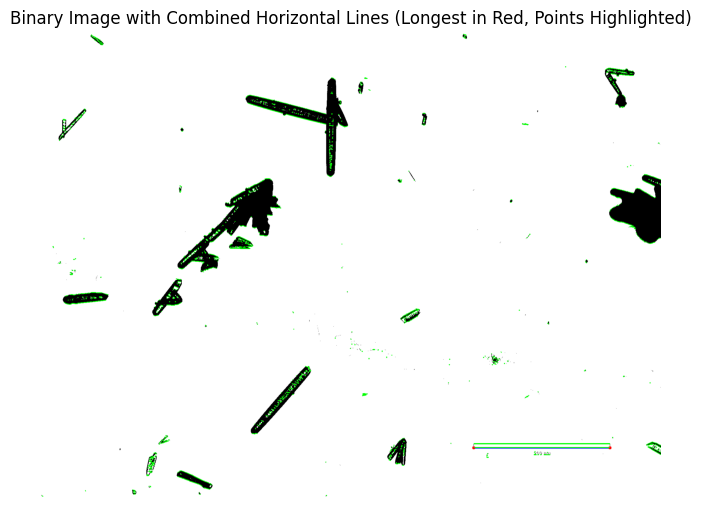

Length of the longest line in pixels: 450.00
Actual length per pixel: 0.4444 micrometers per pixel


In [22]:
from co_mof import detect_horizontal_lines, combine_close_lines, overlay_horizontal_lines, display_overlay
from skimage import measure
import numpy as np


# TODO: what is calculated in this code block that is used in future code blocks? How do these calculations fit into the big picture?
# TODO: calculations should be in functions

# Detect all contours in the binary image using skimage
contours = measure.find_contours(rc_mask, level=0.8)

# Detect horizontal lines in contours
horizontal_lines = detect_horizontal_lines(contours)

# Combine horizontal lines that are close to each other
combined_lines = combine_close_lines(horizontal_lines, pixel_tolerance=5)

# Overlay combined horizontal lines on the binary image and highlight the longest in red
overlay_image, longest_line = overlay_horizontal_lines(rc_mask, combined_lines)

# Display the overlay
display_overlay(overlay_image)

# Assuming the actual length of the longest line is 200 micrometers  # TODO: Why 200?
actual_length_micrometers = 200

# Print details of the longest line  # TODO: should be in function
if longest_line:
    x1, y1, x2, y2 = longest_line
    length_in_pixels = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    length_per_pixel = actual_length_micrometers / length_in_pixels
    print(f"Length of the longest line in pixels: {length_in_pixels:.2f}")
    print(f"Actual length per pixel: {length_per_pixel:.4f} micrometers per pixel")
    
else:
    print("No horizontal lines detected.")
    length_in_pixels = 450
    length_per_pixel = actual_length_micrometers / length_in_pixels

## Morphological Closing on RC Thresholded Image

This script applies **morphological closing** to refine the segmentation from **Ridler-Calvard (RC) thresholding**.

### Steps:
1. **Apply Morphological Closing**:  
   - Enhances the RC thresholded binary image (`rc_mask`) by closing small gaps and noise.
2. **Display Results**:  
   - Shows the original grayscale image, RC thresholded mask, and the morphologically processed image.


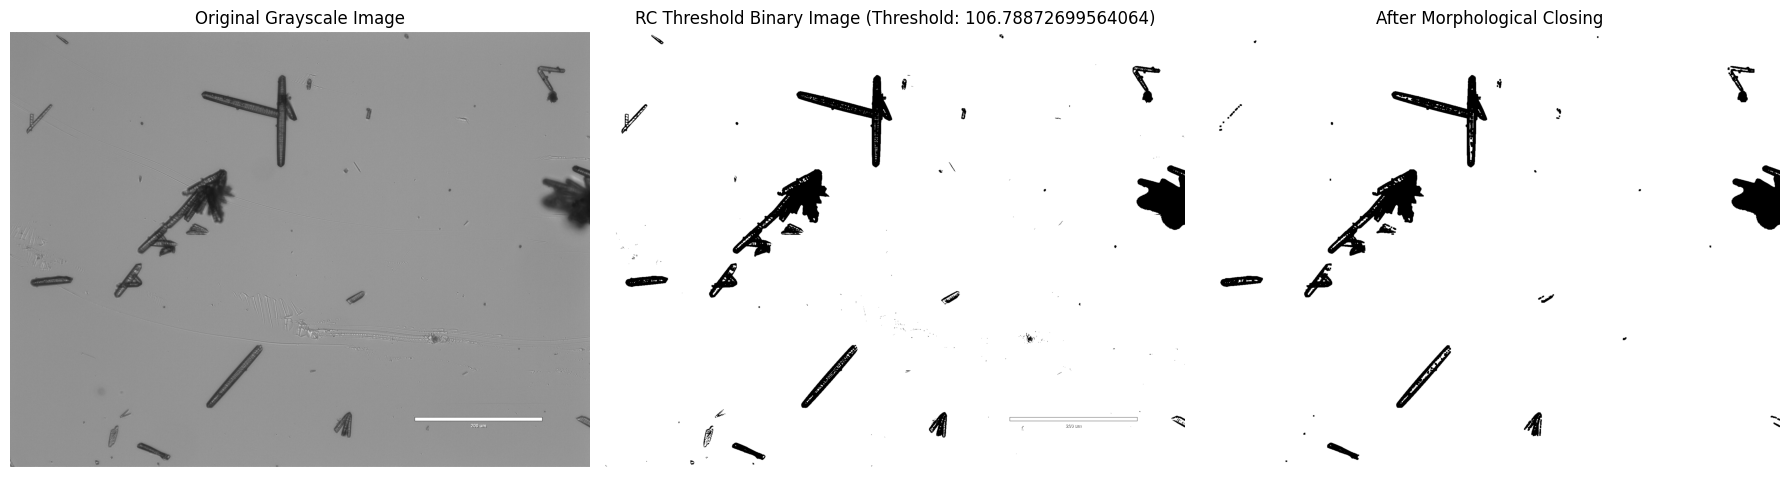

In [23]:
from co_mof import apply_morphological_closing, display_rc_closing_results

# Apply RC thresholding
# rc_thresh, bin_rc = apply_rc_thresholding(image_gray)  # TODO: already did this in cell 1?

# Apply morphological closing on the RC thresholded binary image
closed_image = apply_morphological_closing(rc_mask)

# Display results before and after morphological closing
display_rc_closing_results(image_gray, rc_thresh, rc_mask, closed_image)

## Contour Detection and Filtering

This script detects and filters contours in the binary image.

### Steps:
1. **Find Contours**:  
   - Normalizes `closed_image` and extracts contours using a threshold level of `0.8`.
2. **Filter Contours**:  
   - Removes contours enclosing white regions to focus on relevant structures.
3. **Display Results**:  
   - Overlays the filtered contours onto the processed image.

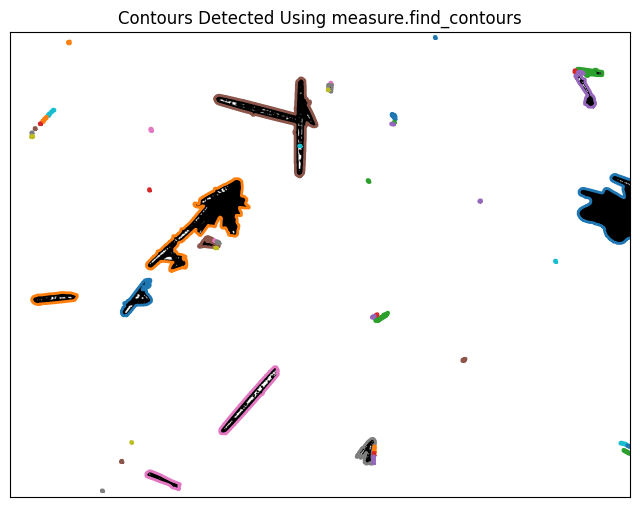

In [24]:
from co_mof import is_contour_enclosing_white_region, normalize_and_find_contours, filter_and_remove_white_region_contours, display_contours

# Example usage:
# Normalize the closing image and find contours
contours = normalize_and_find_contours(closed_image, contour_level=0.8)

# Filter out contours that enclose white regions
contours = filter_and_remove_white_region_contours(closed_image, contours)

# Display the contours on the closing result
display_contours(closed_image, contours)

## Display Contours on Original Image

This script overlays detected contours onto the original microscopic image for better visualization.

### Steps:
1. **Overlay Contours**:  
   - Displays the detected contours overlaid on the original color image for comparison.



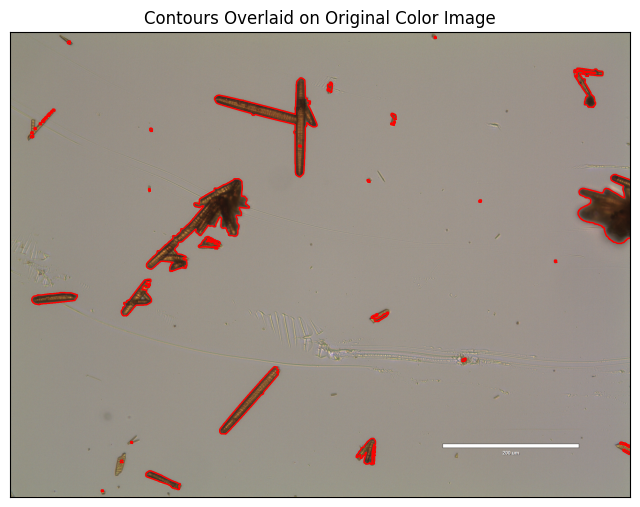

In [25]:
from co_mof import display_contours_on_original_color

# Display the contours overlaid on the original color image
display_contours_on_original_color(image, contours)

In [26]:
from co_mof import process_and_overlay_if_few_contours  # TODO: this looks like it should be broken up into filter & show fxns

# Example Usage: (Run if it is too little, skip it)
# Assuming `original_image`, `blue_contours`, `red_contours`, and `boundary_contours` are defined
Isolated_Crystals_AR, Isolated_Crystals_Area = process_and_overlay_if_few_contours(
    image, contours, length_per_pixel
)

# Output aspect ratios and areas
print("All Aspect Ratios:", Isolated_Crystals_AR)
print("All Areas:", Isolated_Crystals_Area)

Total contours (48) are sufficient. Skipping bounding box overlay.
All Aspect Ratios: []
All Areas: []


## Contour Classification by Convexity

This script classifies detected contours based on their **convexity** and identifies boundary contours.

### Steps:
1. **Classify Contours**:  
   - Segments contours into:
     - **Blue Contours**: Detected isolated crystals and impurities.
     - **Red Contours**: Detected clusters, overlapping crystals, and impurities.

2. **Display Results**:  
   - Overlays classified contours on the original color image for clear visualization.



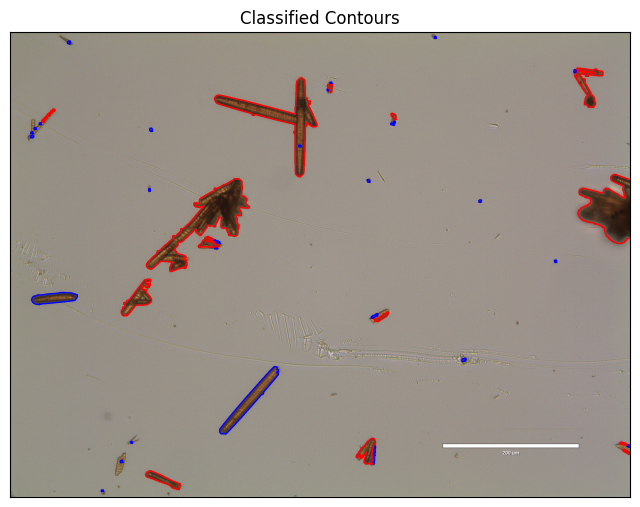

In [27]:
from co_mof import classify_contours_by_convexity, display_classified_contours_on_original_color


# Classify contours based on convexity and identify boundary contours
blue_contours, red_contours= classify_contours_by_convexity(image_gray.shape, contours)

# Display the contours overlaid on the original color image, classified by convexity and boundary
display_classified_contours_on_original_color(image, blue_contours, red_contours)

# Activated IFF less than 2 Detected Contours

## Overlaying Minimum Bounding Boxes and Calculating Aspect Ratios and Areas 

# Else (If more than 2 detected contours)

## Processing Blue Contours

This script analyzes **blue contours** (isolated crystals and impurities) by extracting key measurements.

### Steps:
1. **Calculate Areas**:  
   - Computes the area (in pixe) of each detected blue contour.
2. **Compute Aspect Ratios**:  
   - Determines the aspect ratios of the blue contours.
3. **Output Data**:  
   - Stores **areas** and **aspect ratios** for further analysis.

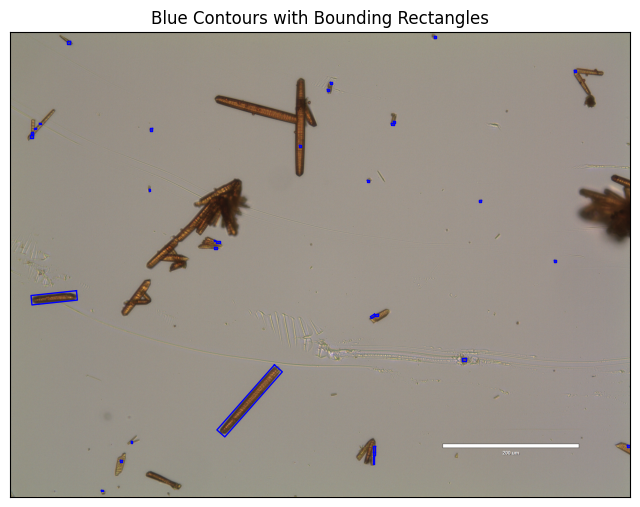

In [28]:
from co_mof import process_blue_contours  # TODO: vague function name
blue_areas, blue_aspect_ratios = process_blue_contours(image_gray, image, blue_contours)

# Histogram Analysis of Blue Contour Properties

This script analyzes the **areas** and **aspect ratios** of blue contours using histograms and statistical measures.

### Steps:
1. **Plot Histograms**:  
   - Displays **top** and **bottom histograms** for contour areas.
   - Fits a **peak curve** to highlight the most common values.
2. **Compute Statistics**:  
   - Extracts **peak values**, **mean**, and **standard deviation** for areas
3. **Output Results**:  
   - Prints the computed statistical values.


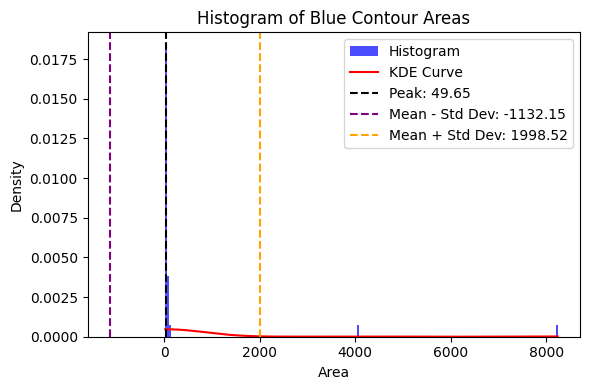

Peak Area: 49.648648648648646
Mean Area: 433.1875, Std Dev Area: 1565.336474162584


In [29]:
from co_mof import plot_area_histogram_with_peak_curve
# Example usage:
peak_area, mean_area, std_area= plot_area_histogram_with_peak_curve(blue_areas)

# Print the peaks and standard deviations  # TODO: should be in function (Does not need to be in a function)
print(f"Peak Area: {peak_area}")
print(f"Mean Area: {mean_area}, Std Dev Area: {std_area}")


## Overlaying Isolated Crystals on the Original Image

This script filters and overlays contours based on statistical analysis of **blue contour areas**.

### Steps:
1. **Adjust Mean Area Threshold** *(Ensuring Most Contours Are Detected)*:  
   - If `mean_area > 5000`, it is adjusted to **500**.  
   - If `mean_area < 1000`, it is adjusted to **200**.
2. **Filter Contours**:  
   - Removes contours exceeding an upper limit derived from statistical values.
   - Outputs:
     - **Filtered Blue Contours** : Isolated Crystals
     - **Filtered Red Contours** : Clusters + Overlapping Crystals
3. **Overlay and Display**:  
   - Shows the processed contours on the original image.
4. **Output Results**:  
   - Prints the number of filtered contours and their areas (scaled by `length_per_pixel`).



## Filtering and Overlaying Contours with Area Limits

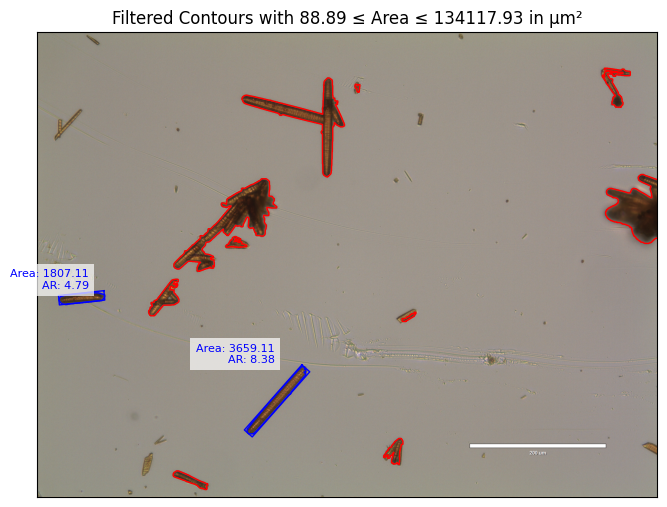

Filtered Blue Contour Areas:
Contour 1: Area = 1807.111111111111
Contour 2: Area = 3659.111111111111


In [30]:
from co_mof import filter_and_overlay_all_contours_with_upper_limit

# Example usage:

# TODO: put below in function
# Replacement of Value (To ensure most contours are detected)
if mean_area > 5000:
    mean_area = 500
            
elif mean_area < 1000:
    mean_area = 200

filtered_blue_contours, Isolated_Crystals_Area, filtered_red_contours, Isolated_Crystals_AR = filter_and_overlay_all_contours_with_upper_limit(
    image, image_gray, blue_contours, red_contours, mean_area, std_area, length_per_pixel
)

# Print the areas of filtered blue contours
print("Filtered Blue Contour Areas:")
for idx, blue_contour_area in enumerate(Isolated_Crystals_Area):
    print(f"Contour {idx + 1}: Area = {blue_contour_area}")

## Removing Edge-Touching Red Contours

This script filters out **red contours** that touch the image edges before further processing.

### Steps:
1. **Detect Edge-Touching Contours**:  
   - Identifies **red contours** that intersect with the image boundary.
2. **Remove Edge Contours**:  
   - Filters out these contours to avoid boundary artifacts.
3. **Display Results**:  
   - Overlays the remaining ** filtered red contours** on the original image for visualization.

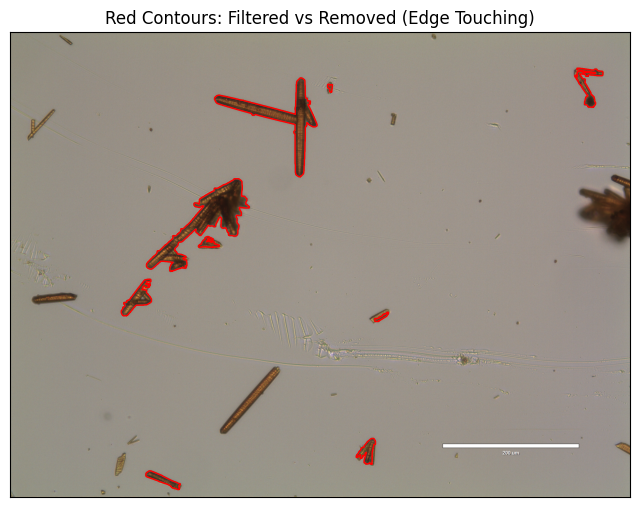

In [31]:
from co_mof import remove_edge_touching_contours_and_display

# Remove and display red contours that touch the edges before filtering
clusters = remove_edge_touching_contours_and_display(filtered_red_contours, image_gray, image, color="red")

## Bounding Box Analysis and Contour Area Calculation

This script calculates the **areas of red clusters** and overlays their bounding boxes on the image.

### Steps:
1. **Draw Bounding Boxes**:  
   - Plots bounding boxes around **Overlapping Crystals and Clusters**.
2. **Calculate Contour Areas**:  
   - Computes area for each red contour, scaled using `length_per_pixel`.
3. **Output Results**:  
   - Prints the calculated contour areas in **µm²**.


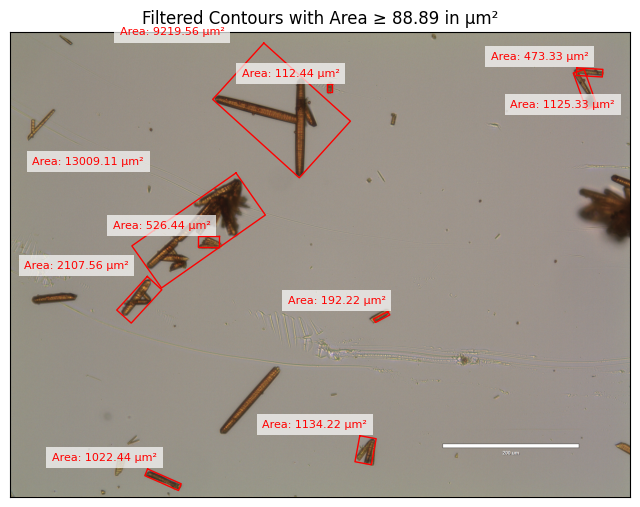

Actual Contour Areas for Filtered Red Contours:
Contour 1: Area = 473.33 µm²
Contour 2: Area = 1125.33 µm²
Contour 3: Area = 9219.56 µm²
Contour 4: Area = 112.44 µm²
Contour 5: Area = 13009.11 µm²
Contour 6: Area = 526.44 µm²
Contour 7: Area = 2107.56 µm²
Contour 8: Area = 192.22 µm²
Contour 9: Area = 1134.22 µm²
Contour 10: Area = 1022.44 µm²


In [32]:
from co_mof import plot_bounding_boxes_and_calculate_contour_area

clusters_areas = plot_bounding_boxes_and_calculate_contour_area(
    clusters, image, mean_area, length_per_pixel, color="red"
)

# Print the calculated contour areas
print("Actual Contour Areas for Filtered Red Contours:")
for idx, area in enumerate(clusters_areas):
    print(f"Contour {idx + 1}: Area = {area:.2f} µm²")

# Data Analysis

## Summary Statistics Calculation and Visualization

This script calculates summary statistics with **standard deviations** for isolated crystals and clusters, ensuring proper formatting for visualization.

### Steps:
1. **Calculate Summary Table**:  
   - Computes mean, standard deviation, and count for:
     - **Isolated Crystals' Aspect Ratios & Areas**
     - **Clusters' Areas**

In [33]:
from co_mof import calculate_summary_with_std

# Calculate summary table with standard deviations
summary_table_with_std = calculate_summary_with_std(
    Isolated_Crystals_AR,
    Isolated_Crystals_Area, clusters_areas
)

# Ensure the plot displays the categories in the correct order
correct_order = ["Isolated Crystals", "Clusters"]
summary_table_with_std = summary_table_with_std.iloc[::-1].reset_index(drop=True)

# Update category labels to have one word per line
summary_table_with_std["Category"] = summary_table_with_std["Category"].replace({
    "Isolated Crystals": "Isolated\nCrystals",
    "Clusters": "Clusters"
})

# # Define bar width
# bar_width = 0.5  # Adjust this value for the desired bar width

# # Plot horizontal bar plot for counts
# plt.figure(figsize=(5, 4))
# plt.barh(summary_table_with_std["Category"], summary_table_with_std["Count"], color='dodgerblue', height=bar_width)
# plt.xlabel("Count", fontsize=14)
# # plt.ylabel("Category", fontsize=14)
# # plt.title("Counts of Crystals and Clusters", fontsize=16)
# plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

## Summary Bar Chart Visualization

This script generates a **bar chart** to summarize key statistical values.

### Steps:
1. **Input Data**:  
   - Uses `summary_table_with_std`, which contains statistical summaries with standard deviations.
2. **Plot Bar Chart**:  
   - Visualizes the summarized data for easy comparison.
3. **Display Results**:  
   - Provides a clear graphical representation of the data distribution.

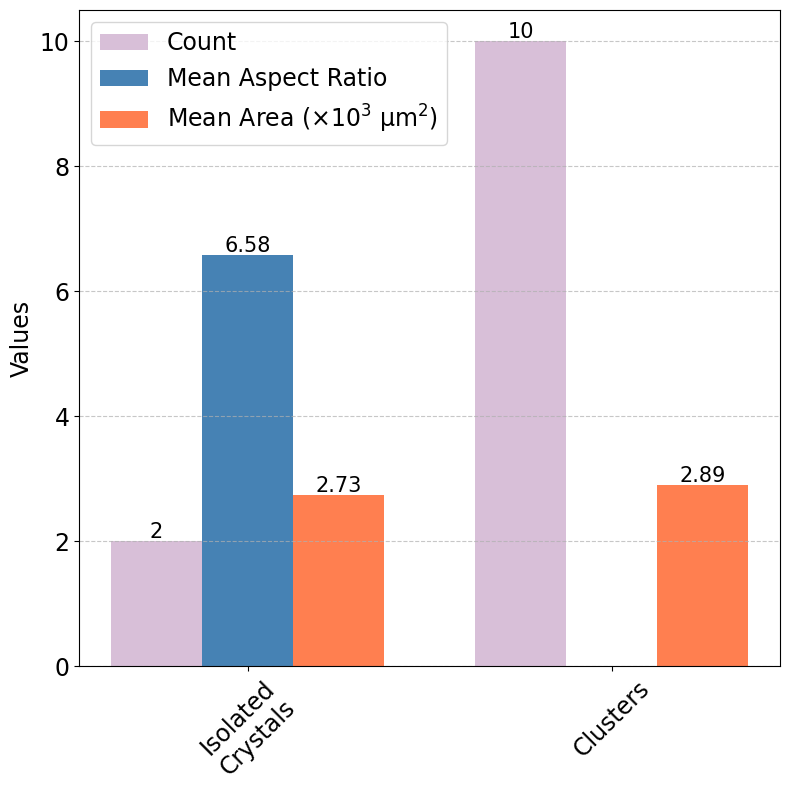

In [34]:
from co_mof import plot_summary_bar_chart

plot_summary_bar_chart(summary_table_with_std)